In [1]:
import igraph
import matplotlib.pyplot as plt
import numpy as np
from os import path
import pandas as pd
import seaborn as sns
from selfregulation.utils.utils import get_behav_data
from selfregulation.utils.r_to_py_utils import psychFA
%matplotlib inline

Note: no visible global function definition for 'radixsort' 



### Load Data

Load both cleaned and imputed data. Set up a helper function to quickly impute data within the Kfold split. Can't use data where imputation was performed over the whole dataset as there will be data leakage between training and test.

In [2]:
datafile = 'Complete_05-13-2017'
# load data
# imputed data
imputed_data = get_behav_data(dataset=datafile, file = 'meaningful_variables_imputed.csv')
imputed_task_data = get_behav_data(dataset=datafile, file = 'taskdata_imputed.csv')
imputed_survey_data = imputed_data.drop(imputed_task_data.columns, axis = 1)
imputed_datasets = {'survey': imputed_survey_data, 'task': imputed_task_data, 'complete': imputed_data}

results = {'survey': {}, 'task': {}, 'complete': {}}

Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Complete_05-13-2017
Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Complete_05-13-2017


Reorder data in some slightly interpretable way

In [3]:
for key, dataset in imputed_datasets.items():
    sorted_columns = []
    survey_cols = ('survey', dataset.filter(regex='survey').columns.tolist())
    drift_cols = ('drift', dataset.filter(regex='\.hddm_drift').columns.tolist())
    drift_contrast_cols = ('drift con', dataset.filter(regex='\..*_hddm_drift').columns.tolist())
    thresh_cols = ('thresh', dataset.filter(regex='\.hddm_thresh').columns.tolist())
    thresh_contrast_cols = ('thresh con', dataset.filter(regex='\..*_hddm_thresh').columns.tolist())
    non_decision_cols = ('non-decision', dataset.filter(regex='\.hddm_non_decision').columns.tolist())
    non_decision_contrast_cols = ('non-decision con', dataset.filter(regex='\..*_hddm_non_decision').columns.tolist())
    stop_cols = ('stop', dataset.filter(regex='stop').columns.tolist())
    discount_cols = ('discount', dataset.filter(regex='discount').columns.tolist())
    leftover_cols = ('misc', dataset.columns)

    tmp_groups = [survey_cols,
                  drift_cols, drift_contrast_cols, 
                  thresh_cols, thresh_contrast_cols,
                  non_decision_cols, non_decision_contrast_cols,
                  stop_cols, discount_cols,
                  leftover_cols]
    putative_groups = []
    results[key]['putative_groups'] = putative_groups
    for name, group in tmp_groups:
        group = sorted(list(set(group)-set(sorted_columns)))
        sorted_columns+=group
        putative_groups.append((name,group))
    imputed_datasets[key] = dataset.reindex_axis(sorted_columns, axis=1)

# Calculate best number of components

### Define Helper functions

In [4]:
def find_optimal_components(data):
    BICs = []
    outputs = []
    n_components = range(1,20)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    for c in n_components:
        fa, output = psychFA(scaled_data, c, method='ml')
        BICs.append(output['BIC'])
        outputs.append(output)
    best_c = np.argmin(BICs)+1
    print('Best Component: ', best_c)
    return best_c, BICs

### Calculate best number of components using BIC (R Psych package)

In [5]:
for label,data in imputed_datasets.items():
    print('Dataset: %s' % label)
    best_c, BICs = find_optimal_components(data)
    results[label]['best_c'] = best_c
    results[label]['BICs'] = BICs


Dataset: survey


/home/ian/anaconda2/envs/py34/lib/python3.4/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required namespace: GPArotation

  warnings.warn(x, RRuntimeWarning)


Best Component:  12
Dataset: task
Best Component:  8
Dataset: complete
Best Component:  10


### Plot Component's BIC

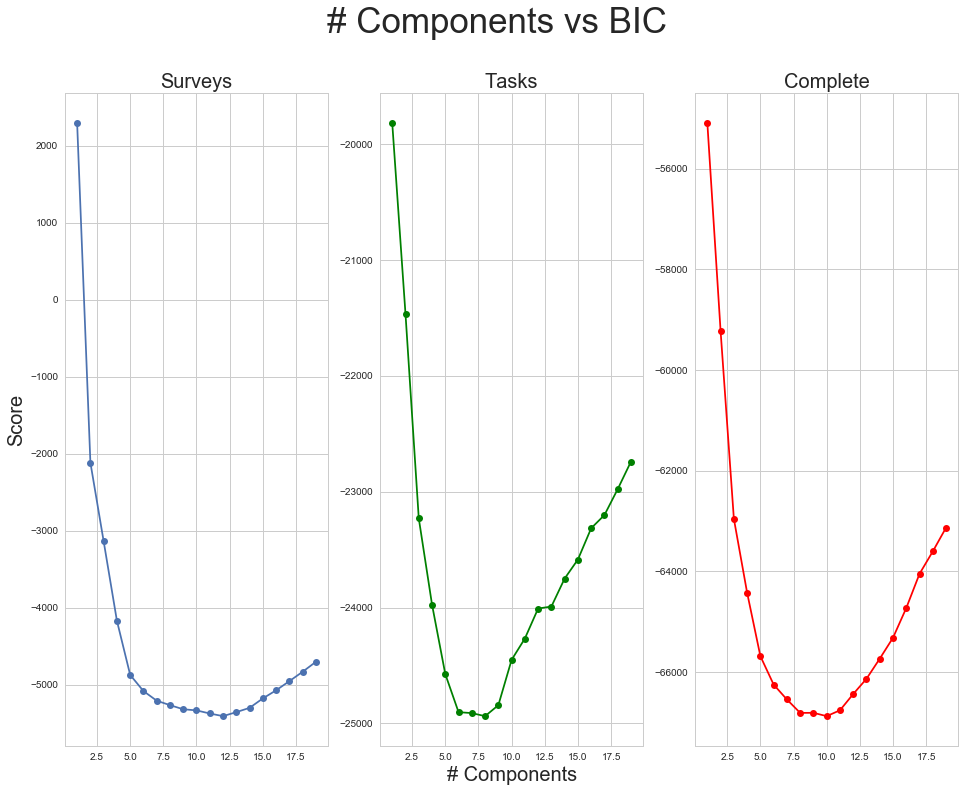

In [6]:
sns.set_style('whitegrid')

fig = plt.figure(figsize=(16,12))
ax1 = plt.subplot2grid((3, 3), (0, 0), rowspan=3)
ax2 = plt.subplot2grid((3, 3), (0, 1), rowspan=3)
ax3 = plt.subplot2grid((3, 3), (0, 2), rowspan=3)


plot_data = results['survey']['BICs']
ax1.plot(range(1,len(plot_data)+1),plot_data, '-o')
ax1.set_ylabel('Score', fontsize = 20)
ax1.set_title('Surveys', fontsize = 20)

plot_data = results['task']['BICs']
ax2.plot(range(1,len(plot_data)+1),plot_data, '-go')
ax2.set_xlabel('# Components', fontsize = 20)
ax2.set_title('Tasks', fontsize = 20)

plot_data = results['complete']['BICs']
ax3.plot(range(1,len(plot_data)+1),plot_data, '-ro')
ax3.set_title('Complete', fontsize = 20)

fig.suptitle('# Components vs BIC', fontsize = 35)

# Interpret Factor Analysis Solutions
Above we found that the best number of components were as follows:

**Psych**:

Task: {{results['task']['psych_best_c']}}

Survey: {{results['survey']['psych_best_c']}}

Complete: {{results['complete']['psych_best_c']}}

First we will look at the best number of components, then we will look at the solution at each dimensionality and plot the relationships between dimensions

In [7]:
# Helper Functions
def get_loadings(fa_output, labels):
    loading_df = pd.DataFrame(fa_output['loadings'], index=labels)
    # sort by maximum loading on surveys
    sorting_index = np.argsort(loading_df.filter(regex='survey',axis=0).abs().mean()).tolist()[::-1]
    loading_df = loading_df.loc[:,sorting_index]
    loading_df.columns = range(loading_df.shape[1])
    return loading_df

# Print top variables for each factor
def print_top_factors(loading_df, n = 4):
    # number of variables to display
    for i,column in loading_df.iteritems():
        sort_index = np.argsort(abs(column))[::-1] # descending order
        top_vars = column[sort_index][0:n]
        print('\nFACTOR %s' % i)
        print(top_vars)

## Select Data: Complete Dataset (Surveys and tasks)


In [8]:
# perform factor analysis
complete_results = results['complete']
best_c = complete_results['best_c']
data = imputed_datasets['complete']
putative_groups = results['complete']['putative_groups']
fa, output = psychFA(data, best_c)

## Print top loading factors for optimal dimensionality

In [9]:
loading_df = get_loadings(output, labels=data.columns)
print_top_factors(loading_df, 10)


FACTOR 0
time_perspective_survey.future                                      0.868852
upps_impulsivity_survey.lack_of_perseverance                       -0.770718
bis11_survey.Nonplanning                                           -0.767206
upps_impulsivity_survey.lack_of_premeditation                      -0.680496
self_regulation_survey.control                                      0.667986
selection_optimization_compensation_survey.optimization.ReflogTr   -0.618133
ten_item_personality_survey.conscientiousness                       0.616849
grit_scale_survey.grit                                              0.568488
brief_self_control_survey.self_control                              0.551673
bis11_survey.Motor                                                 -0.540277
Name: 0, dtype: float64

FACTOR 1
ten_item_personality_survey.emotional_stability    -0.677890
bis_bas_survey.BIS                                  0.672070
five_facet_mindfulness_survey.nonjudge             -0.671252
tim

## Do the components seem to capture surveys and tasks differently?

Yes, it seems that the surveys and tasks largely separate amongst the different components.

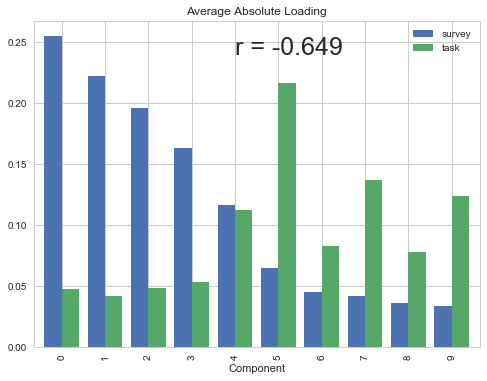

In [10]:
# get absolute average loadings for surveys and tasks per component
abs_survey_loadings = loading_df.filter(regex='survey', axis=0).iloc[:,:best_c].abs().mean()
abs_task_loadings = loading_df.drop(loading_df.filter(regex='survey', axis=0).index, axis=0).iloc[:,:best_c].abs().mean()
abs_average_loadings = pd.concat([abs_survey_loadings, abs_task_loadings],axis=1)
abs_average_loadings.columns = ['survey','task']

# plot
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8,6))
abs_average_loadings.plot(kind='bar',legend=True, width=.8,  ax = ax)
plt.xlabel('Component')
ax.set_title('Average Absolute Loading')
# add correlation of two components to plot
corr = abs_average_loadings.corr().iloc[0,1]
ax.text(4,.24, 'r = %.3f' % corr, fontsize=25)


## Visualize loadings of components on each variable

In [11]:
from matplotlib.backends.backend_pdf import PdfPages

# Helper functions for visualization of component loadings
def plot_loadings(ax,component_loadings, groups):
    """
    Takes in an axis, a vector and a list of groups and 
    plots the loadings. If a polar axis is passed this will
    result in a polar bar plot, otherwise a normal bar plot will
    be made. 
    """
    colors = sns.hls_palette(len(groups), l=.5, s=.8)
    ax.set_xticklabels([''])
    ax.set_yticklabels([''])
    
    N = len(component_loadings)
    theta = np.arange(0.0, 2*np.pi, 2*np.pi/N)
    radii = component_loadings
    width = np.pi/(N/2)*np.ones(N)
    bars = ax.bar(theta, radii, width=width, bottom=0.0)
    for i,r,bar in zip(range(N),radii, bars):
        color_index = sum((np.cumsum([len(g[1]) for g in groups])<i))
        bar.set_facecolor(colors[color_index])
        bar.set_alpha(1)
    plt.legend()
    return colors
        
def create_categorical_legend(labels,colors, ax):
    """
    Takes in a list of labels and colors and creates a legebd
    for an axis object which assigns each label to the corresponding
    color
    """
    import matplotlib
    descriptions = [g[0] for g in putative_groups]
    def create_proxy(color):
        line = matplotlib.lines.Line2D([0], [0], linestyle='none',
                    mec='none', marker='o', color=color)
        return line
    proxies = [create_proxy(item) for item in colors]
    ax.legend(proxies, labels, numpoints=1, markerscale=2.5, bbox_to_anchor=(1, .5), prop={'size':15})
    
def visualize_factors(loading_df,groups,n_cols=2, legend=True):
    """
    Takes in a dataset to run EFA on, and a list of groups in the form
    of a list of tuples. Each element of this list should be of the form
    ("group name", [list of variables]). Each element of the list should
    be mututally exclusive. These groups are used for coloring the plots
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    loading_df = loading_df.select_dtypes(include=numerics)
    n_components = loading_df.shape[1]
    n_rows = np.ceil(n_components/n_cols)
    sns.set_style("white")
    fig = plt.figure(figsize=(n_rows*5,n_cols*5))
    for i in range(n_components):
        component_loadings = loading_df.iloc[:,i]
        ax=plt.subplot(n_cols,n_rows,i+1,polar=True)
        colors = plot_loadings(ax,abs(component_loadings),groups)
    fig.tight_layout()
    if legend:
        create_categorical_legend([g[0] for g in groups],colors,ax)
    return fig

def save_factor_tree(data, groups, filename, component_range=(1,13), reorder_list=None):
    """
    Runs "visualize_factors" at multiple dimensionalities and saves them
    to a pdf
    data: dataframe to run EFA on at multiple dimensionalities
    groups: group list to be passed to visualize factors
    filename: filename to save pdf
    component_range: limits of EFA dimensionalities. e.g. (1,5) will run
                     EFA with 1 component, 2 components... 5 components.
    reorder_list: optional. List of index values in an order that will be used
                  to rearrange data
    """
    if reorder_list:
        data = data.iloc[:,reorder_list]
    pp = PdfPages(filename)
    for c in range(component_range[0],component_range[1]+1):
        fa, output = psychFA(data, c)
        tmp_loading_df = get_loadings(output, labels=data.columns)
        if c == 1:
            fig = visualize_factors(tmp_loading_df, groups, n_cols=1)
        else:
            fig = visualize_factors(tmp_loading_df, groups, n_cols=1, legend=False)
        pp.savefig(fig, bbox_inches='tight')
        fig.clear()
    pp.close()

### Group variables by putative labels defined above

/home/ian/anaconda2/envs/py34/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


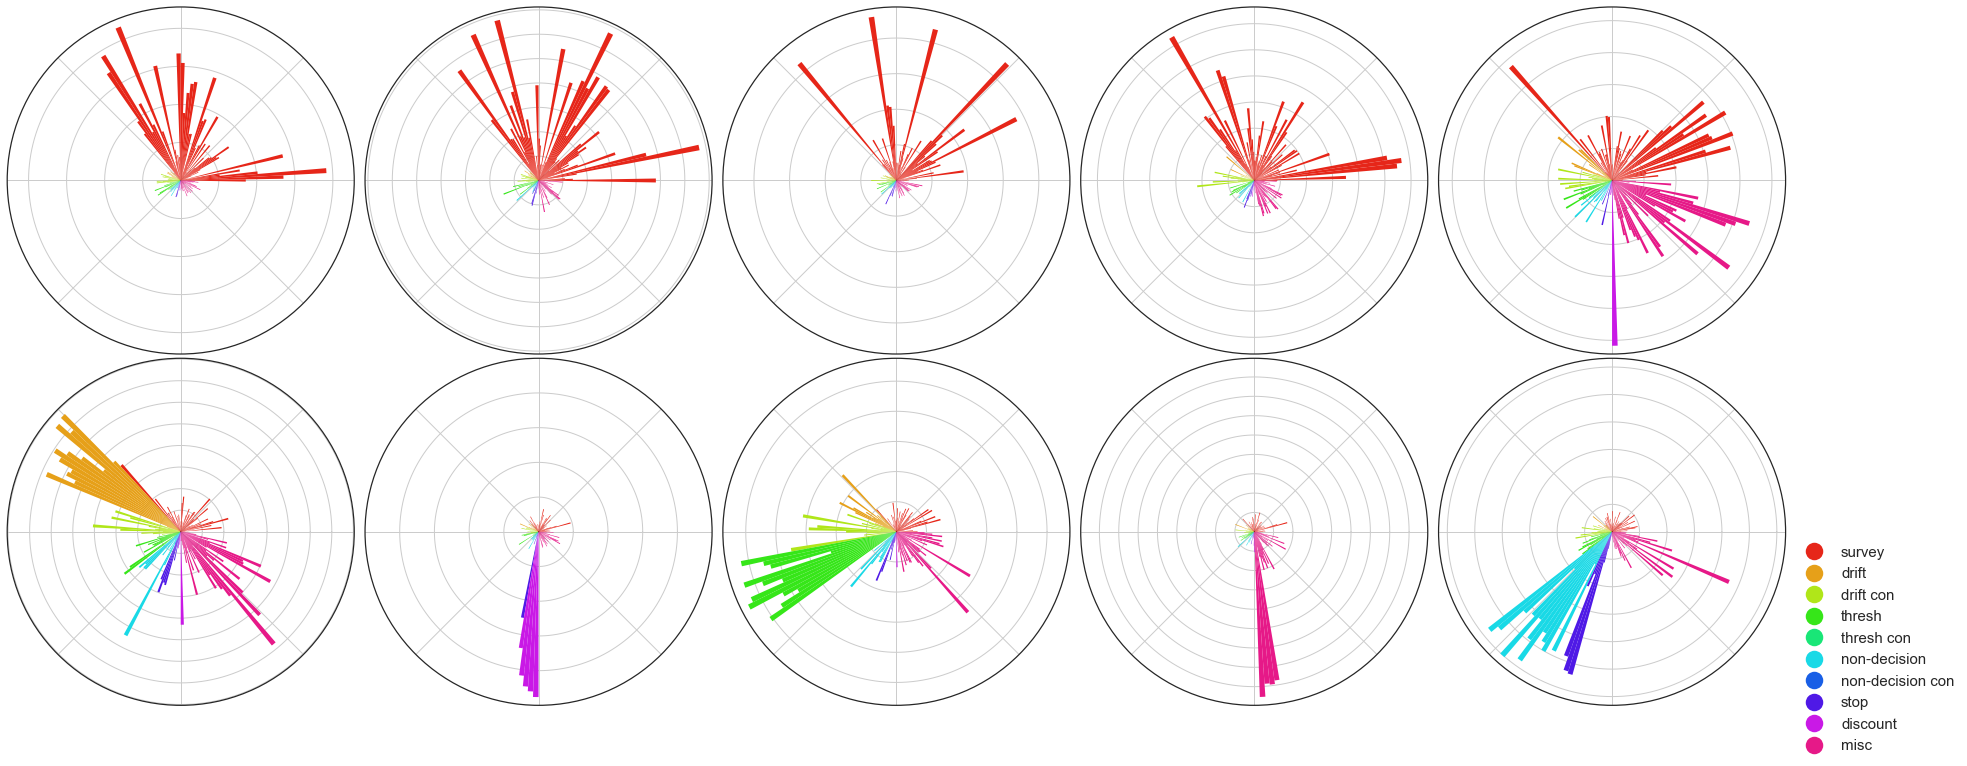

In [93]:
# example graph, taking an arbitary 4 components
fig = visualize_factors(loading_df, putative_groups)

Save polar factor loading plots for a number of dimensionalities

In [13]:
save_location = path.join('Plots', 'EFA_Polar_Plots_putative.pdf')
# For other dimensionalities
data = imputed_datasets['complete']
putative_groups = results['complete']['putative_groups']
save_factor_tree(data,putative_groups, save_location, (1,12))

/home/ian/anaconda2/envs/py34/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


### Group variables by clusters over the optimal number of components

Below I create a correlation matrix of each variable's absolute loading on each component. This is a representation of the similarity of each variable in the component space defined by the optimal number of components.

Once I do that I cluster the variables hierarchically, and cut the tree at a particular point to group the variables. This serves as algorithmically derived groups rather than the putative groups I used before. These groups are only useful for visualization purposes. The goal is to understand the variables in terms of optimal EFA clusters, and use that understanding at different dimensionalities

In [78]:
# helper function
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
def get_hierarchical_groups(loading_df, n_groups=8):
    # create linkage matrix for variables projected into a component loading
    row_clusters = linkage(abs(loading_df).T.corr().values, method='ward', metric='euclidean')   
    # use the dendorgram function to order the leaves appropriately
    row_dendr = dendrogram(row_clusters, labels=loading_df.T.columns, no_plot = True)
    cluster_reorder_index = row_dendr['leaves']
    # cut the linkage graph such that there are only n groups
    n_groups = n_groups
    index_assignments = [i[0] for i in cut_tree(row_clusters,n_groups)]
    # using the groups and the dendrogram ordering, create a number of groups
    hierarchical_groups = []
    for assignment in np.unique(index_assignments):
        # get variables that are in the correct group
        assignment_vars = [var for i,var in enumerate(cluster_reorder_index) if index_assignments[i] == assignment]
        hierarchical_groups.append((assignment,assignment_vars))
    return cluster_reorder_index, hierarchical_groups

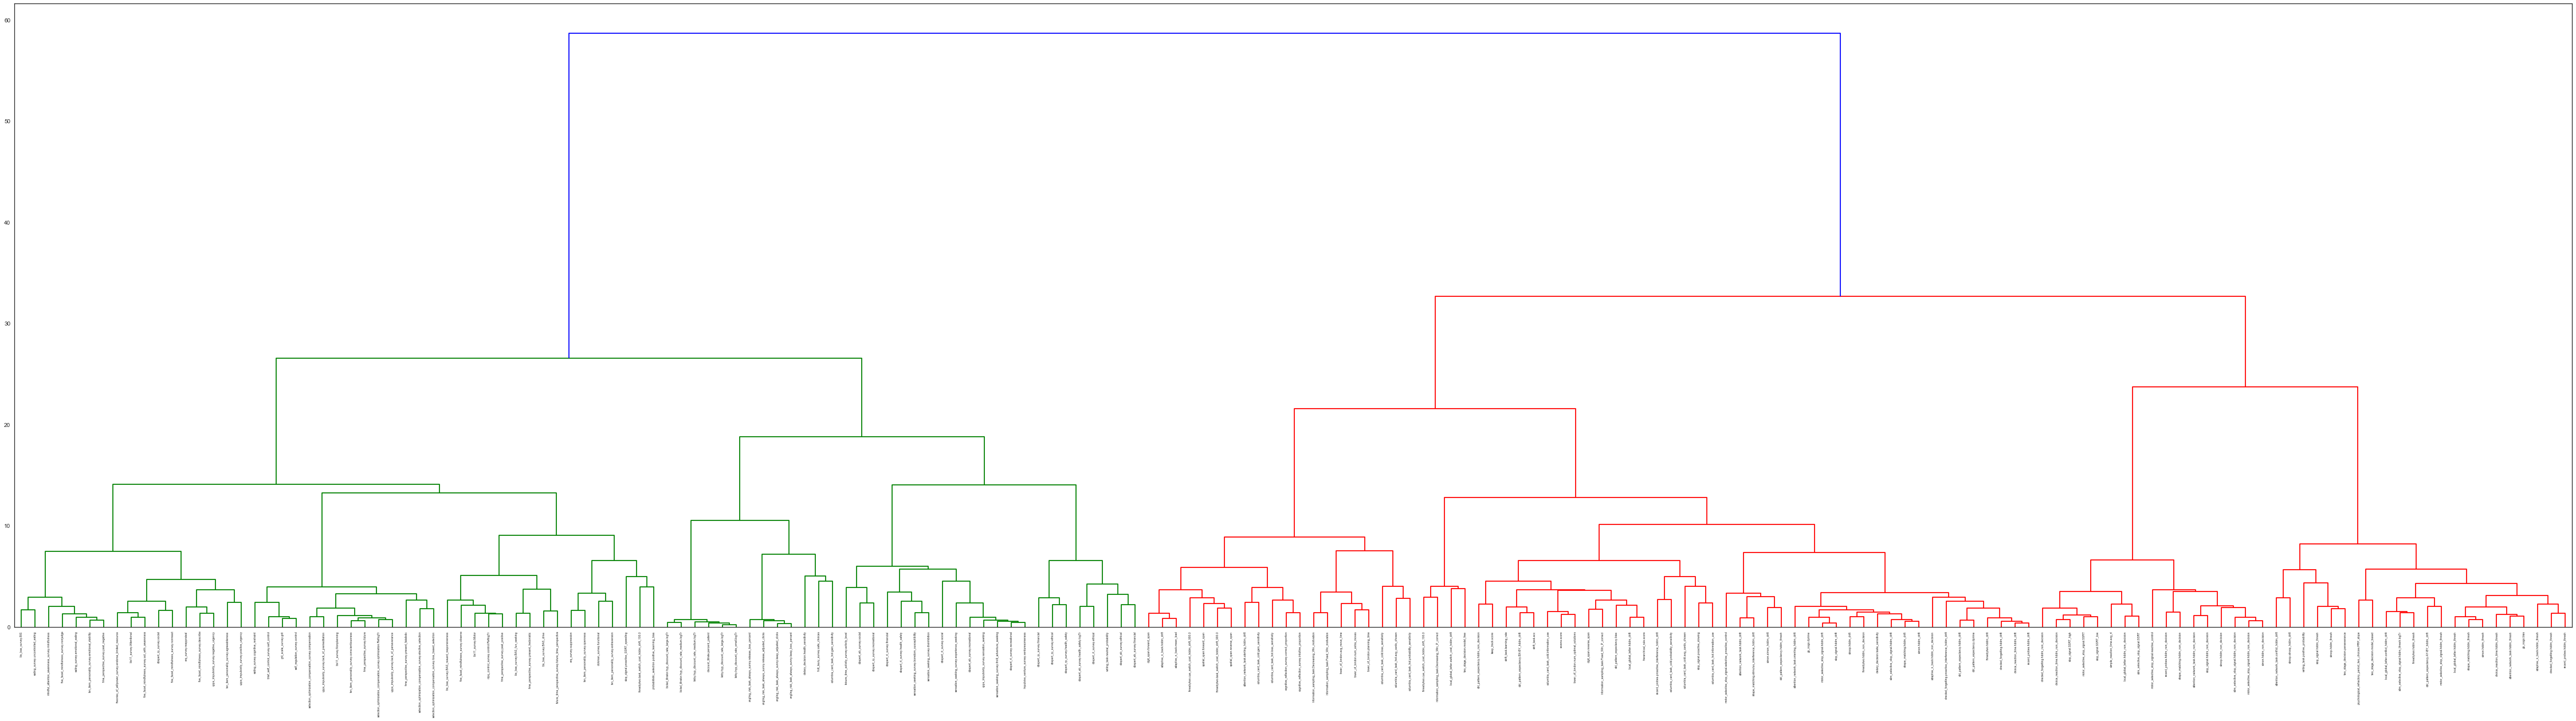

In [94]:
row_clusters = linkage(abs(loading_df).T.corr().values, method='ward', metric='euclidean')   
# use the dendorgram function to order the leaves appropriately
plt.figure(figsize=(80,20))
row_dendr = dendrogram(row_clusters, labels=loading_df.T.columns, no_plot = False)

In [89]:
# Perform clustering on the optimal loading dataframe
data = imputed_datasets['complete']
cluster_reorder, hierarchical_groups = get_hierarchical_groups(loading_df, n_groups=7)
for i, group in hierarchical_groups:
    group_vars = data.columns[group]
    print('\nFACTOR %s' % i)
    print(group_vars)



FACTOR 0
Index(['bis_bas_survey.BIS', 'eating_survey.uncontrolled_eating',
       'mindful_attention_awareness_survey.mindfulness',
       'five_facet_mindfulness_survey.nonjudge',
       'eating_survey.emotional_eating',
       'ten_item_personality_survey.emotional_stability',
       'time_perspective_survey.past_negative',
       'theories_of_willpower_survey.endorse_limited_resource',
       'dospert_rp_survey.social', 'self_regulation_survey.control',
       'selection_optimization_compensation_survey.optimization.ReflogTr',
       'upps_impulsivity_survey.lack_of_perseverance',
       'time_perspective_survey.present_fatalistic',
       'selection_optimization_compensation_survey.elective_selection',
       'selection_optimization_compensation_survey.loss_based_selection',
       'bis_bas_survey.BAS_reward_responsiveness',
       'five_facet_mindfulness_survey.observe', 'bis11_survey.Motor',
       'mpq_control_survey.control.ReflogTr',
       'time_perspective_survey.past_posit

In [91]:
save_location = path.join('Plots', 'EFA_Polar_Plots_hierarchical.pdf')
save_factor_tree(data, hierarchical_groups, save_location, (1,13), reorder_list=cluster_reorder)

/home/ian/anaconda2/envs/py34/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [61]:
# getting counts of words in each group
import re
from itertools import chain
from collections import Counter

def split(string):
    return re.split("[_\.]", string)
    
words = [list(data.columns[g[1]]) for g in hierarchical_groups]
vec = list(chain.from_iterable([split(w) for w in words[2]]))
counts = pd.Series(vec).value_counts()

## Plot relationships between solutions at different dimensionalities

Each factor analytic solution gives us some components. By correlating the components at one level with the next, we can get a sense for how similar these components are. When we move to 3 dimensions from 2, is it the case that one of the dimensions just split? Or is there a new, non-hierarchical parcellation of the space?



In [16]:
# helper functions for plotting dimensionality relations
# compute FA with different dimensionalities and quantify similarity
def dimensional_similarity(factors, reference):
    ''' This function returns an N x M correlation matrix where N is the number
    of reference (lower dimension) factors and M is the number of higher dimension
    factors
    '''
    relation = np.corrcoef(reference.T, factors.T)
    # each row is a reference factor, each column a new factor
    relation=relation[:reference.shape[1], reference.shape[1]:]
    return relation

def construct_relational_tree(similarities, labels=None, filey=None):
    ''' Takes a list of similarities and constructs a tree graph, then plots
    '''
    G = igraph.Graph()
    layer_start = 0
    colors = ['red','blue','green','violet']*10
    for similarity in similarities:
        curr_color = colors.pop()
        origin_length = similarity.shape[0]
        target_length = similarity.shape[1]
        if len(G.vs)==0:
            G.add_vertices(origin_length)
        G.add_vertices(target_length)
        for i in range(origin_length):
            for j in range(target_length):
                G.add_edge(i+layer_start,j+origin_length+layer_start,
                           weight=abs(similarity[i,j]*5),color = curr_color)
        layer_start+=similarity.shape[0]
    layout = G.layout_reingold_tilford(root = [0])
    if labels == None:
        labels = G.vs.indices
    plot = igraph.plot(G, layout=layout, **{'inline': True, 'vertex_label': labels, 
                                            'vertex_color': 'white',
                                            'vertex_size': 20, 
                                         'edge_width':[w for w in G.es['weight']], 
                                         'edge_color': G.es['color'], 
                                            'bbox': (1000,1000), 'margin':100})
    if filey:
        plot.save(filey)
    #G.write_dot('test.dot')
    return G


In [17]:
# construct array of component similarities
similarities = []
components = range(1,13)
reference = None
for c in components:
    fa, output = psychFA(data,c)
    result = pd.DataFrame(output['scores'], data.index)
    if reference is not None:
        similarity = dimensional_similarity(result,reference)
        similarities.append(similarity)
    reference = result

In [18]:
# plot component similarity tree
labels = []
#for c in components:
#    labels+=factor_names[c]
similarity_tree = construct_relational_tree(similarities, 
                                            labels=None, filey=path.join('Plots', 'task_graph.png'))